In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import optuna

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashionmnist


In [3]:
# prompt: write code for checking gpu availability

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Using device: cuda


In [4]:
df = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(60000, 785)

In [5]:
#Seed for reproducibility
torch.manual_seed(42)

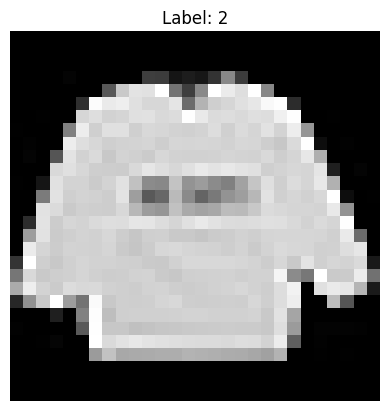

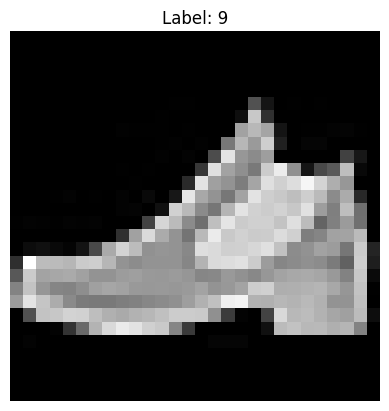

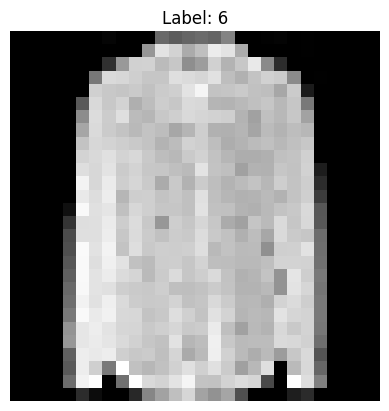

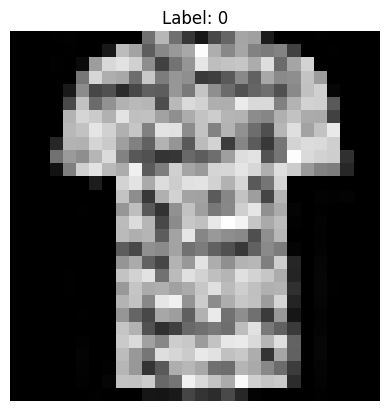

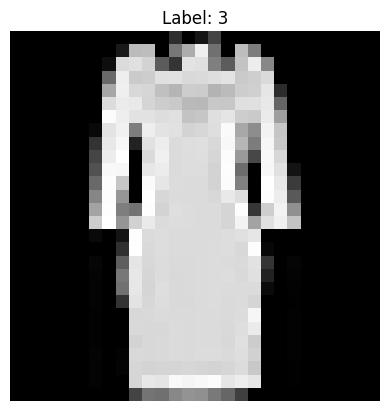

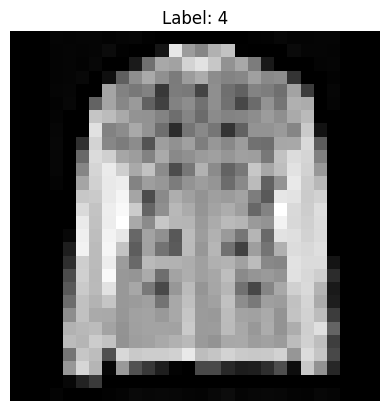

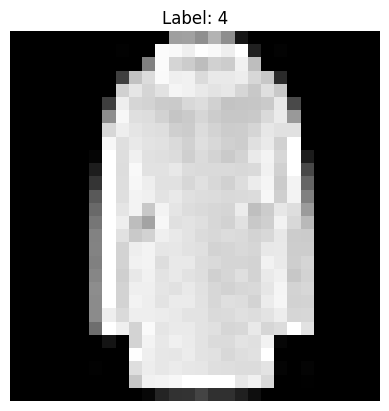

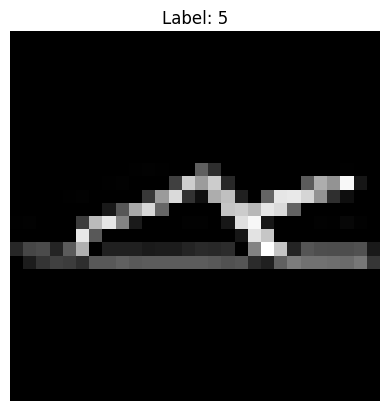

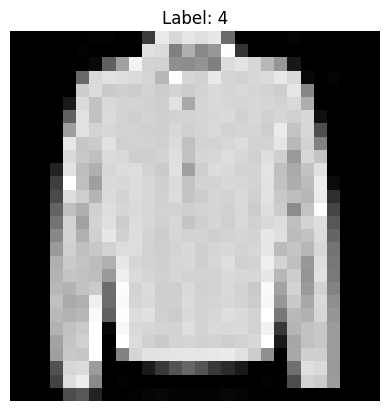

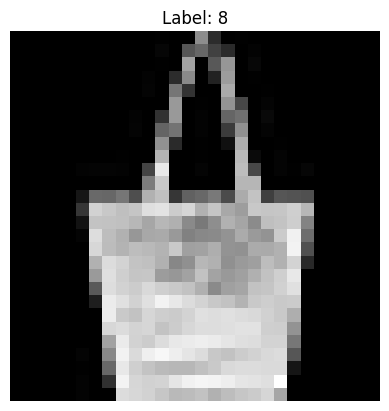

In [6]:
# Function to display an image from the dataset
def display_image(pixels, label):
    image = pixels.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

# Display the first few images
num_images_to_display = 10
for i in range(num_images_to_display):
    label = df.iloc[i, 0]
    pixels = df.iloc[i, 1:].values.astype(np.uint8) # Ensure pixel values are uint8
    display_image(pixels, label)

In [7]:
X =  df.iloc[:, 1:].values
y = df.iloc[:, :1].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Scaling the features
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
# Create CustomDataset Class
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    # Flatten the target labels to be 1D
    self.y = torch.tensor(y, dtype=torch.long).squeeze()

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

  def __len__(self):
    return len(self.X)

In [11]:
# Create train_dataset object
train_dataset = CustomDataset(X_train, y_train)

In [12]:
# Create test_dataset object
test_dataset = CustomDataset(X_test, y_test)

In [ ]:
# Neural Network

class ANN(nn.Module):
  def __init__(self, input_size):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        #nn.Dropout(0.5),  # 30% dropout
        nn.Linear(128,64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.5),  # 40% dropout
        nn.Linear(64,10)
    )

  def forward(self, x):
    return self.model(x)

In [50]:
# Neural Network for Optuna

class myANN(nn.Module):
  def __init__(self, input_size, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_size, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))

      input_size = neurons_per_layer
      neurons_per_layer = neurons_per_layer // 2

    layers.append(nn.Linear(input_size, output_dim))
    layers.append(nn.Softmax(dim=1))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)




In [51]:
# Optuna - Objective Function
def objective(trail):

  # Extract values from search space
  num_hidden_layers = trail.suggest_int('num_hidden_layers', 1, 5)
  neurons_per_layer = trail.suggest_int('neurons_per_layer', 32, 256, step = 8)
  epochs = trail.suggest_int('epochs', 10, 50, step = 10)
  learning_rate = trail.suggest_float('learning_rate', 1e-5, 1e-1, log = True)
  dropout_rate = trail.suggest_float('dropout_rate', 0.0, 0.5, step = 0.1)
  batch_size = trail.suggest_categorical('batch_size', [32, 64, 128])
  optimizer_name = trail.suggest_categorical('optimizer', ['Adam', 'SGD'])

  # Data Loaders
  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, pin_memory= True)
  test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, pin_memory= True)

  # Model init
  input_dim = X_train.shape[1]
  output_dim = 10

  model = myANN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model = model.to(device)


  # Loss Function
  criterion = nn.CrossEntropyLoss()

  # Optimizer
  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4)
  elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 1e-4)

  # Training loop
  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # Moving training data batches to GPU
      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)

      # Forward pass
      outputs = model(batch_features)

      # Calculate loss
      loss = criterion(outputs, batch_labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()

      # Update parameters
      optimizer.step()

  # Evaluation Loop
  model.eval()

  total = 0
  correct = 0

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:

      batch_features = batch_features.to(device)
      batch_labels = batch_labels.to(device)

      y_pred = model(batch_features)

      y_pred = torch.argmax(y_pred, dim=1)

      total = total + (batch_labels.shape[0])
      correct = correct + (batch_labels == y_pred).sum().item()

  accuracy = correct / total

  return accuracy

In [52]:
# Create an Optuna study object
# The 'direction' parameter is set to 'maximize', indicating that Optuna should try to maximize the objective function (model's accuracy).
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

[I 2025-07-11 23:10:31,348] A new study created in memory with name: no-name-723866a0-23d8-4289-bf1f-a0185fb8fde0


In [53]:
study.optimize(objective, n_trials=10)

[I 2025-07-11 23:12:56,809] Trial 0 finished with value: 0.8376666666666667 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 176, 'epochs': 50, 'learning_rate': 0.0033661169488457747, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8376666666666667.
[I 2025-07-11 23:13:25,692] Trial 1 finished with value: 0.8289166666666666 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 112, 'epochs': 10, 'learning_rate': 4.948132584840135e-05, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8376666666666667.
[I 2025-07-11 23:17:12,986] Trial 2 finished with value: 0.8266666666666667 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 104, 'epochs': 40, 'learning_rate': 0.00010922153724109638, 'dropout_rate': 0.2, 'batch_size': 32, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.8376666666666667.
[I 2025-07-11 23:17:58,454] Trial 3 finished with value: 0.348583

In [48]:
study.best_value

0.8375

In [49]:
study.best_params


{'num_hidden_layers': 1, 'neurons_per_layer': 208, 'optimizer': 'SGD'}

In [ ]:
## Boilerplate code
patience = 0
# Training Loop
for epoch in range(num_epochs):
  total_epoch_loss = 0.0
  total_validation_loss = 0.0
  for batch_features, batch_labels in train_loader:

    # Moving training data batches to GPU
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # Forward pass
    outputs = model(batch_features)

    # Calculate loss
    loss = criterion(outputs, batch_labels)
    total_epoch_loss += loss.item()
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

  # VAlidation loss
  for batch_features, batch_labels in test_loader:

    # Moving training data batches to GPU
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)

    # Forward pass
    outputs = model(batch_features)

    # Calculate loss
    loss = criterion(outputs, batch_labels)
    total_validation_loss += loss.item()

  avg_loss = total_epoch_loss / len(train_loader)
  avg_validation_loss = total_validation_loss / len(test_loader)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Loss: {avg_validation_loss:.4f}')



Epoch [1/50], Loss: 0.5871, Validation Loss: 0.4813
Epoch [2/50], Loss: 0.4645, Validation Loss: 0.4438
Epoch [3/50], Loss: 0.4390, Validation Loss: 0.4542
Epoch [4/50], Loss: 0.4288, Validation Loss: 0.4150
Epoch [5/50], Loss: 0.4194, Validation Loss: 0.4227
Epoch [6/50], Loss: 0.4127, Validation Loss: 0.4433
Epoch [7/50], Loss: 0.4078, Validation Loss: 0.4232
Epoch [8/50], Loss: 0.4027, Validation Loss: 0.4304
Epoch [9/50], Loss: 0.3998, Validation Loss: 0.4210
Epoch [10/50], Loss: 0.3994, Validation Loss: 0.4261
Epoch [11/50], Loss: 0.3997, Validation Loss: 0.4143
Epoch [12/50], Loss: 0.3935, Validation Loss: 0.4308
Epoch [13/50], Loss: 0.3970, Validation Loss: 0.4410
Epoch [14/50], Loss: 0.3905, Validation Loss: 0.4065
Epoch [15/50], Loss: 0.3853, Validation Loss: 0.4162
Epoch [16/50], Loss: 0.3934, Validation Loss: 0.4198
Epoch [17/50], Loss: 0.3821, Validation Loss: 0.4087
Epoch [18/50], Loss: 0.3851, Validation Loss: 0.4178
Epoch [19/50], Loss: 0.3860, Validation Loss: 0.4393
Ep